In [2]:
import sys
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from time import time
from sklearn.metrics import precision_score,recall_score

sys.path.append("../Enron_Corpus/tools")
from feature_format import featureFormat, targetFeatureSplit
#from tester import dump_classifier_and_data

In [3]:
# Task 1: Select what features you'll use.
# features_list is a list of strings, each of which is a feature name.
# The first feature must be "poi".
features_list = ['salary','bonus'] # You will need to use more features

In [4]:
# Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [5]:
print(len(data_dict))

146


## Visualize the data

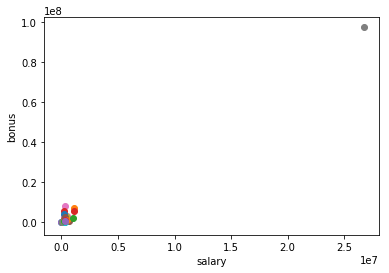

In [6]:
def visualize():
    data = featureFormat(data_dict,features_list)
    for point in data:
        salary = point[0]
        bonus = point[1]
        plt.scatter( salary, bonus )
    plt.xlabel("salary")
    plt.ylabel("bonus")
    plt.show()

    # labels,features = targetFeatureSplit(data)
    # plt.scatter(labels,features)
    # plt.xlabel("POI")
    # plt.ylabel("Salary")
    # plt.show()
visualize()

After Visualizing the data, it is clear that there is a outlier which needs to be removed.

## Outlier Removal

(26704229, 'TOTAL')


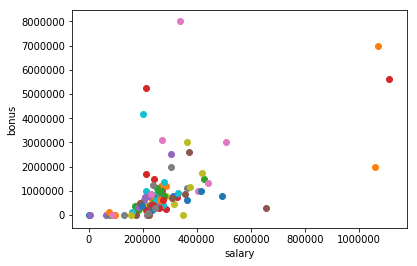

In [7]:
#Finding the outlier
max_salary,max_key = 0,''
for key,value in data_dict.items():
    if value['salary'] > max_salary and value['salary']<>'NaN':
        max_salary, max_key = value['salary'],key
        
print(max_salary,max_key)

#Removing the outlier
data_dict.pop('TOTAL')

#Visualize after removing the outlier
visualize()

After removing the oulier, the data is now quite easy to visualize.
There are few outliers still there. But we cannot remove them, they might be the actual people involved in the fraud.
We'll see who these people are.

In [8]:
outliers = []
for key in data_dict:
    sal = data_dict[key]['salary']
    if sal<>'NaN':
        outliers.append((key,int(sal)))

outliers_final = (sorted(outliers,key=lambda x:x[1],reverse=True)[:4])
print(outliers_final)
        

[('SKILLING JEFFREY K', 1111258), ('LAY KENNETH L', 1072321), ('FREVERT MARK A', 1060932), ('PICKERING MARK R', 655037)]


In [ ]:
# sys.path.append("../Enron_Corpus/Outlier")
# from outlier_removal_regression import outlierRemovalRegression
# labels,features = targetFeatureSplit(data)
# outlierRemovalRegression(features,labels)

# Feature Processing

Using my intuition, I am using two features('from_poi_to_this_person' and 'from_this_person_to_poi') that are already present in the data.

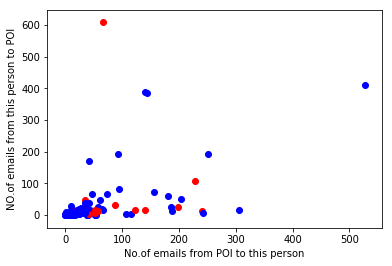

In [9]:
#Selecting two features from the existing data.
features_list = ['poi','from_poi_to_this_person','from_this_person_to_poi']
data = featureFormat(data_dict,features_list)

for point in data:
    from_poi = point[1]
    to_poi = point[2]
    if point[0]==1:
        plt.scatter(from_poi,to_poi,c="r")
    else:
        plt.scatter(from_poi,to_poi, c='b')

plt.xlabel("No.of emails from POI to this person")
plt.ylabel("NO.of emails from this person to POI")
plt.show()

There is no strong pattern visualized here that differentiate POI from non-POI.
So, I modified these two features to use fraction of them.

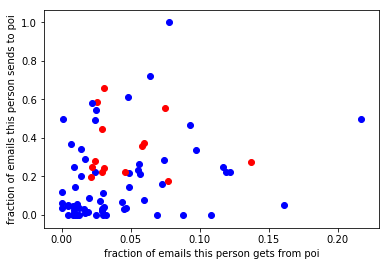

In [10]:
def fraction_feature(new_feature,key,norm):
    
    for emp in data_dict.keys():
        
        if data_dict[emp][key]<>'NaN' and data_dict[emp][norm]<>'NaN':
            div = float(data_dict[emp][key])/data_dict[emp][norm]
            data_dict[emp][new_feature] = round(div,3)
        else:
            data_dict[emp][new_feature] = 0.0

fraction_feature("fraction_from_poi_email","from_poi_to_this_person","to_messages")
fraction_feature("fraction_to_poi_email","from_this_person_to_poi","from_messages")

#new features
features_list = ['poi',"fraction_from_poi_email","fraction_to_poi_email"]
data = featureFormat(data_dict,features_list)

for point in data:
    from_poi = point[1]
    to_poi = point[2]
    if point[0]==1:
        plt.scatter(from_poi,to_poi,c="r")
    else:
        plt.scatter(from_poi,to_poi, c='b')

plt.xlabel("fraction of emails this person gets from poi")
plt.ylabel("fraction of emails this person sends to poi")
plt.show()

These two new features are very well discriminating POIs from non-POIs, so now lets try use them for classification task.

# Algorithm Selection and Tuning

In [11]:
features_list = ['poi',"fraction_from_poi_email","fraction_to_poi_email","shared_receipt_with_poi"]
data = featureFormat(data_dict,features_list)
labels,features=targetFeatureSplit(data)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.1,
                                                                             random_state=42)
t1 = time()
clf = GaussianNB()
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
accuracy = accuracy_score(pred,labels_test)
print 'Accuracy',round(accuracy,2)
print "Precision: ",round(precision_score(labels_test,pred),2)
print "Recall: ", round(recall_score(labels_test,pred),2)
print "NB algo. time",round(time()-t1, 3),'sec'

Accuracy 0.67
Precision:  0.0
Recall:  0.0
NB algo. time 0.008 sec


##### I used naive bayes algorithm here and the accuracy is 67%, which is very low.
Lets use decisionTree classifier for this task.

In [12]:
from sklearn.tree import DecisionTreeClassifier
t1 = time()
clf = DecisionTreeClassifier(min_samples_split=5)
clf = clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
accuracy = accuracy_score(pred,labels_test)
print 'Accuracy',round(accuracy,2)
print "Precision: ",round(precision_score(labels_test,pred),2)
print "Recall: ", round(recall_score(labels_test,pred),2)
print "DecisionTree Clf algo. time",round(time()-t1, 3),'sec'

Accuracy 0.78
Precision:  0.5
Recall:  0.5
DecisionTree Clf algo. time 0.008 sec


# Analysis Validation and Performance

In [13]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)
print(kf)
count=0
for trainIndex, testIndex in kf.split(labels):
    features_train = [features[index] for index in trainIndex]
    features_test =  [features[index] for index in testIndex]
    labels_train =   [labels[index] for index in trainIndex]
    labels_test =    [labels[index] for index in testIndex]



KFold(n_splits=3, random_state=None, shuffle=False)


In [16]:
clf = DecisionTreeClassifier(min_samples_split=6)
clf = clf.fit(features_train,labels_train)
pred = clf.predict(features_test)
accuracy = accuracy_score(labels_test,pred)
t1 = time()
print 'Accuracy',round(accuracy,2)
print "Precision: ",round(precision_score(labels_test,pred),2)
print "Recall: ", round(recall_score(labels_test,pred),2)
print "DecisionTree Clf algo. time",round(time()-t1, 3),'sec'

Accuracy 0.93
Precision:  0.67
Recall:  0.67
DecisionTree Clf algo. time 0.008 sec
